<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Labs/Week_9_Generative_modeling_Charlotte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Exercise) Autoencoders, Generative Adversarial Networks, and Diffusion Models

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Th%C3%A9%C3%A2tre_D%E2%80%99op%C3%A9ra_Spatial.png/920px-Th%C3%A9%C3%A2tre_D%E2%80%99op%C3%A9ra_Spatial.png)

Théâtre D'opéra Spatial, 2022 artwork created by Jason M. Allen with Midjourney

The code in this notebook is inspired by the work of Aurélien Géron, particularly his book (Hands-on ML) and accompanying exercise notebooks. Additionally, valuable insights and techniques have been drawn from the comprehensive tutorials and resources provided by https://machinelearningmastery.com.

**Autoencoders**, **GANs**, and **Diffusion Models** are all machine learning algorithms that can generate new data, often in an unsupervised manner. **Autoencoders** learn to compress and decompress data, capturing underlying patterns. **GAN**s (Generative adversarial networks) use two competing neural networks: a generator that creates new data and a discriminator that evaluates its authenticity. **Diffusion Models** gradually add noise to data and then learn to remove it, producing realistic samples. These models have applications in image generation, style transfer, and more.

We'll be implementing them on the [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html) dataset to explore their capabilities in **capturing patterns, image generation and style transfer**. These models offer powerful techniques for learning latent representations, generating new data, and understanding complex patterns within data.


*Note* : CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

**Learning Objectives:**

1. Implement VAEs, GANs, and Diffusion Models in TensorFlow.
2. Understand the key differences and trade-offs between these models.
3. Experiment with hyperparameters to improve model performance.

<font color='red'>Running all parts of this notebook can be time-consuming. Feel free to reduce the number of epochs or interrupt the training process if it takes too long.</font>

## Imports and Data Loading

In [1]:
%%capture
%pip install tensorflow-gpu==2.8.0

# You may need to restart the runtime to use the
# specific `tf` version installed for this notebook

In [2]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
from packaging import version
from sklearn.manifold import TSNE

# make notebook reproducible
tf.random.set_seed(42)

# make plot prettier
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Check if right modules are installed
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
# for easy plotting later on
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

<font color='red'>You may need to restart the runtime the first time you run it to use the specific `tf` version installed for this notebook</font>

### **Q1) Load the dataset, scale it, and split it into a training set, a validation set, and a test set**

In [8]:
# Load the CIFAR-10 dataset using tf.keras.datasets.cifar10.load_data
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [9]:
# Normalize the pixel values to the range [0, 1]
# RGB values are between 0 and 256
X_train = X_train / 256.0
X_test = X_test / 256.0


In [10]:
# Split the training set into a training set and a validation set
# Get 5000 images as the validation set
# Get the first 5000 images as the validation set
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]



In [12]:
### Get familiar with CIFAR-10 dataset
# Get the shape of the images
print(X_train.shape, X_valid.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


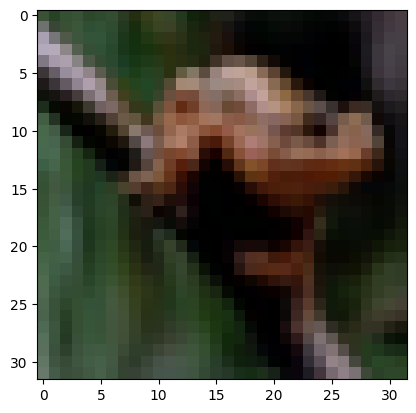

In [13]:
# Display a sample image
plt.imshow(X_train[0])

## 亖 Stacked Autoencoders

Autoencoders, like other neural networks, can employ multiple hidden layers, often referred to as **stacked autoencoders** or **deep autoencoders**. This layered architecture enables autoencoders to learn progressively more complex representations of the input data.

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).



Each epoch with this recommended parameters will take ~ 1 min 10 sec;


### **Q2) Complete the stacked autoencoder architecture below**

In [14]:
# Define the stacked encoder architecture
# Recommended 512, 256 units for the Dense layers and ReLU activation
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
])


In [16]:
# Define the stacked decoder architecture
# Recommended 512 and pixel count in one image as units for the Dense layers
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(32 * 32 * 3),
    tf.keras.layers.Reshape([32, 32, 3])
])


In [17]:
# Combine encoder and decoder into the stacked autoencoder
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])


In [21]:
# Compile the stacked autoencoder
# Recommended loss is MSE and recommended optimizer is NAdam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Nadam

MSE = MeanSquaredError()
# Use a different variable name for the optimizer instance,
# or simply pass 'Nadam' to the optimizer argument
optimizer = Nadam()

stacked_ae.compile(loss=MSE, optimizer=optimizer)


In [22]:
# Train the stacked autoencoder
# We want the predictions to be as the input (X == y)
# Recommended epochs is 10
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))


Epoch 1/10
1407/1407 [==============================] - 110s 77ms/step - loss: 0.0273 - val_loss: 0.0267
Epoch 2/10
1407/1407 [==============================] - 105s 75ms/step - loss: 0.0178 - val_loss: 0.0222
Epoch 3/10
1407/1407 [==============================] - 105s 74ms/step - loss: 0.0154 - val_loss: 0.0141
Epoch 4/10
1407/1407 [==============================] - 106s 75ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 5/10
1407/1407 [==============================] - 106s 75ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 6/10
1407/1407 [==============================] - 103s 73ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 7/10
1407/1407 [==============================] - 101s 72ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 8/10
1407/1407 [==============================] - 104s 74ms/step - loss: 0.0113 - val_loss: 0.0129
Epoch 9/10
1407/1407 [==============================] - 101s 72ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 10/10
1407/1407 [==============================] 

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:



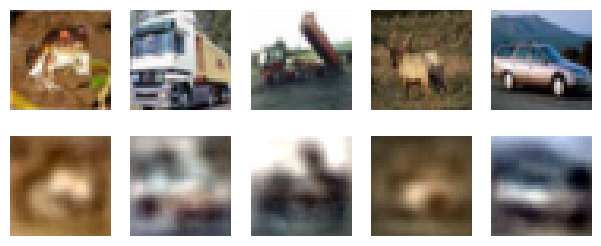

In [23]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index]) #, cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index]) #, cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

<font color='red'>The reconstructions look fuzzy, but remember that the images were compressed down to just 256 (or whatever number of neurons in your last layer you choosed) numbers, instead of 3072.</font>

### **Q3) Visualize the CIFAR-10 dataset using [tsne](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)**

In [25]:
# Predict the validation set
X_valid_compressed = stacked_encoder.predict(X_valid)


In [26]:
# Apply t-SNE for dimensionality reduction
# You can initializes with PCA, and the learning_rate to auto
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)


In [27]:
# Transform the compressed validation set into 2D
X_valid_2D = tsne.fit_transform(X_valid_compressed)


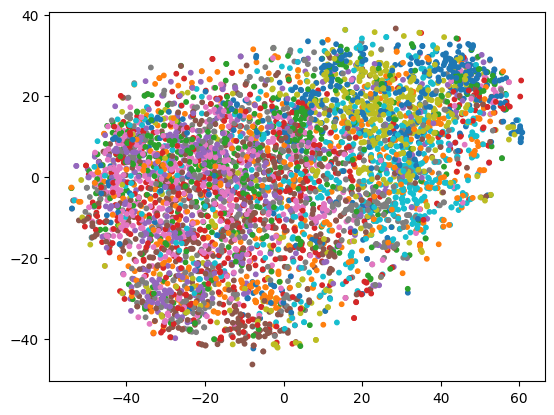

In [28]:
# Plot the 2D data
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram prettier:

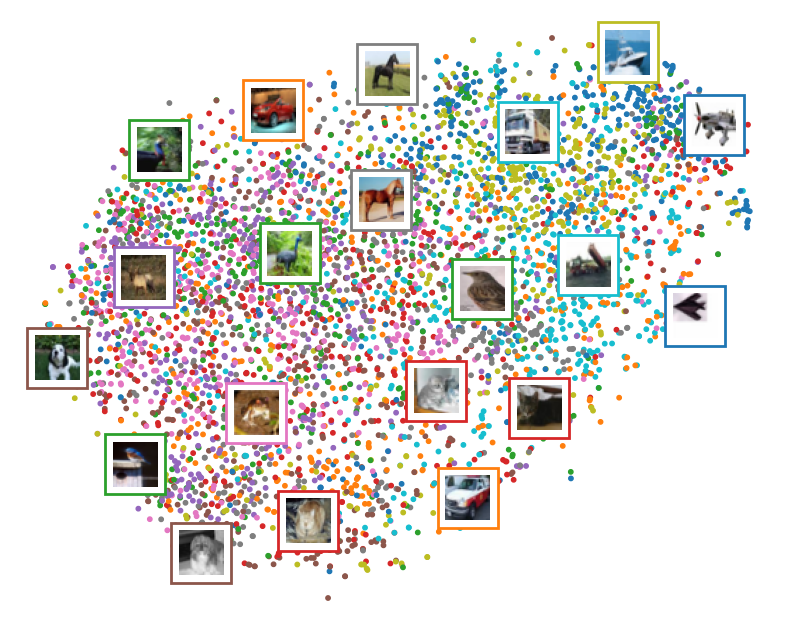

In [29]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

## [OPTIONAL] ⊩ Denoising Autoencoders

To make autoencoders learn better features, we can add noise to their inputs and train them to remove the noise and recover the original data. This is called **denoising autoencoding**.

The implementation is straightforward: it's a standard stacked autoencoder with an additional Dropout layer applied to the encoder's inputs. You could also use a GaussianNoise layer instead.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout.

*Note* : both Dropout and GaussianNoise layers are only active during training.

### **Q4) Complete the denoising autoencoder architecture below**

In [ ]:
# Define the denoising encoder
denoising_encoder = tf.keras.Sequential([
    # GaussianNoise adds noise for robustness (0.1)
    tf.keras.layers.GaussianNoise(___),
    # Conv2D extracts features with 32 filters and (3x3) kernel, `same` padding, ReLU as activation
    tf.keras.layers.Conv2D(___, ___, padding=___, activation=___),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    # Dense layer with 512 units for feature processing, ReLU as activation
    tf.keras.layers.Dense(___, activation=___)
])

In [ ]:
# Define the denoising decoder architecture
denoising_decoder = tf.keras.Sequential([
    # Dense layer reshapes the compressed data back to match the decoder's input shape
    tf.keras.layers.Dense(___ * ___ * ___, activation=___),
    # Reshape changes the 1D vector back into 16x16x32 feature maps
    tf.keras.layers.Reshape([___, ___, ___]),
    # Conv2DTranspose performs upsampling (opposite of Conv2D) to restore the original image size
    # Use 3 filters, 3 as kernel size, 2 as strides, `same` padding, `sigmoid` as activation
    tf.keras.layers.Conv2DTranspose(filters=___, kernel_size=___, strides=___,
                                    padding=___, activation=___)
])

In [ ]:
# Combine encoder and decoder into the denoising autoencoder
denoising_ae = tf.keras.Sequential([___, ___])

# Compile the autoencoder
# Using binary crossentropy for the loss function and Nadam optimizer and MSE metric
# Metrics: Mean Squared Error to monitor reconstruction quality
denoising_ae.compile(loss=___, optimizer=___, metrics=[___])

# Train the autoencoder
# Input and target are the same (denoising task), with 10 epochs and validation data
history = denoising_ae.fit(___, ___, epochs=___, validation_data=(___, ___))

### **Q5) Try generating images from noisy inputs. What do you notice?**

In [ ]:
# Number of images to process (e.g. 5)
n_images = __

# Select a subset of test images
new_images = X_test[:___]

# Add noise to these images and scale it by various factors (e.g., 0.1)
new_images_noisy = new_images + np.random.randn(___, 32, 32, 3) * ___

# Predict denoised images using the autoencoder
new_images_denoised = denoising_ae.predict(___)

# Plot the original, noisy and denoised images
plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()

The images show examples of noisy images and the corresponding images reconstructed by the GaussianNoise-based denoising autoencoder.

This demonstrates that denoising autoencoders can not only be used for data visualization or unsupervised pretraining but also for effectively removing noise from images.

## [OPTIONAL] ଽ Variational Autoencoders

**Variational autoencoders (VAEs)** are different from other autoencoders because they use randomness to create their outputs. Instead of just producing a single code for an input, VAEs create a range of possible codes. This randomness helps them create new data that looks like the original data.

Here's how it works:

1. **Encoder:** The encoder takes an input and creates two things: a mean code and a standard deviation.
2. **Sampling:** A random code is chosen from a range based on the mean and standard deviation.
3. **Decoder:** The decoder uses this random code to create an output that looks similar to the original input.

In [ ]:
# Define a custom Keras layer for sampling from a normal distribution
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        # Sample using reparameterization trick
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


### **Q6) Complete the VAE architecture below**

In [ ]:
# Define the size of the latent space (e.g. 10)
codings_size = ___

# Create input layer for 32x32x3 CIFAR images
inputs = tf.keras.layers.Input(shape=[__, __, _])

# Flatten input, then pass through Dense layers with ReLU activation
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(___, activation="relu")(Z)
Z = tf.keras.layers.Dense(___, activation="relu")(Z)

# Compute mean and log variance for the latent space
codings_mean = tf.keras.layers.Dense(___)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(___)(Z)  # γ

# Sample from the latent space using the mean and log variance
codings = Sampling()([___, ___])

# Define the encoder model
variational_encoder = tf.keras.Model(
    inputs=[___],
    # the outputs are: mean, log variance and codings
    outputs=[___, ___, ___]
    )

In [ ]:
# Create input layer for the latent space
decoder_inputs = tf.keras.layers.Input(shape=[___])

# Pass through Dense layers to reconstruct the original image
# Recommended number of units are: 100, 150, and image size
x = tf.keras.layers.Dense(___, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(___, activation="relu")(x)
x = tf.keras.layers.Dense(___)(x)
# Reshape as 32x32x3 CIFAR images
outputs = tf.keras.layers.Reshape([__, __, _])(x)

# Define the decoder model
variational_decoder = tf.keras.Model(inputs=[___], outputs=[___])

In [ ]:
# Encode inputs to get latent space codings
dummy_var1, dummy_var2, codings = variational_encoder(___)

# Decode codings to reconstruct the inputs
reconstructions = variational_decoder(___)

# Define the variational autoencoder model with the reconstructions as output
variational_ae = tf.keras.Model(inputs=[___], outputs=[___])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)

variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

### **Q7) Train the variational autoencoder to reconstruct the CIFAR images**

In [ ]:
# Compile the variational autoencoder
# Use Mean Squared Error for loss and Nadam optimizer for training
variational_ae.compile(loss=___, optimizer=___)

# Train the variational autoencoder
# Fit the model using training data with e.g. 25 epochs and e.g. 128 batch size
history = variational_ae.fit(X_train, X_train, epochs=___, batch_size=___,
                             validation_data=(X_valid, X_valid))

In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index]) #, cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index]) #, cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_ae)
plt.show()

## 🅶 GANs


Generative Adversarial Networks (**GAN**s) represent one of the most fascinating concepts in computer science today. They involve training two models in tandem through an adversarial process. The generator, often called "the artist," learns to produce images that appear realistic, while the discriminator, known as "the art critic," learns to distinguish between genuine images and those created by the generator.

During training, the generator gets better at making realistic images, while the discriminator gets better at spotting fakes. They reach a balance when the discriminator can't tell real images from fake ones anymore.

### **Q8) Complete the GAN architecture below**

In [31]:
# Define the size of the latent space, e.g. 30
codings_size = 30


In [32]:
# Build the generator model
Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(300, activation="relu", kernel_initializer="he_normal"),  # Expand to 300 units
    Dense(450, activation="relu", kernel_initializer="he_normal"),  # Expand to 450 units
    Dense(32 * 32 * 3, activation="sigmoid"),  # Output layer to match 32x32x3 image
    tf.keras.layers.Reshape([32, 32, 3])  # Reshape to 32x32x3 CIFAR image
])


In [33]:
# Build the discriminator model
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  # Flatten the input image
    Dense(450, activation="relu", kernel_initializer="he_normal"),  # Hidden layer with 450 units
    Dense(300, activation="relu", kernel_initializer="he_normal"),  # Hidden layer with 300 units
    Dense(1, activation="sigmoid")  # Output layer for binary classification
])


In [34]:
# Combine generator and discriminator into a GAN
# The GAN model consists of the generator followed by the discriminator
gan = tf.keras.Sequential([generator, discriminator])

In [36]:
# Compile the discriminator model
# Uses binary cross-entropy loss for binary classification and RMSprop optimizer
discriminator.compile(loss='binary_crossentropy', optimizer='RMSprop')

In [37]:
# Set discriminator to non-trainable when training the GAN to freeze its weights
discriminator.trainable = False

In [38]:
# Compile the GAN model
# Uses binary cross-entropy loss and RMSprop optimizer for training the GAN
gan.compile(loss='binary_crossentropy', optimizer='RMSprop')

In [39]:
# Define batch size for training
batch_size = 32


In [40]:
# Create a TensorFlow dataset from the training data
# Shuffle the data with a buffer size of 1000 for randomness
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)


In [41]:
# Batch the data into chunks of size batch_size
# Prefetch data to improve performance by overlapping data preprocessing and model training
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### **Q9) Train the GAN to generate new images**

In [ ]:
# Helper function to train the GAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_batch = tf.cast(X_batch, tf.float32)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

In [ ]:
# Train the GAN model, with e.g. 50 epochs

In [ ]:
#@markdown Fill in the blank code. Double-click here to reveal
# Train the GAN model, with e.g. 50 epochs
train_gan(gan, dataset, batch_size, codings_size, n_epochs=___)

In [ ]:
# Generate a batch of latent vectors


In [ ]:
# Generate images using the trained generator (using the `codings`)


In [ ]:
# Plot the generated images, e.g. 5


In [ ]:
#@markdown Fill in the blank code. Double-click here to reveal
# Generate a batch of latent vectors
codings = tf.random.normal(shape=[batch_size, codings_size])

# Generate images using the trained generator (using the `codings`)
generated_images = generator.predict(___)

# Plot the generated images, e.g. 5
plot_multiple_images(generated_images, ___)
plt.show()

## [OPTIONAL] 灬🅶 Deep Convolutional GANs

Deep GANs (Generative Adversarial Networks) are a type of GAN that use deep neural networks in both the generator and the discriminator. By leveraging deep architectures, these models can create more complex and realistic images or data.

### **Q10) Complete the deep convolutional GAN architecture below**

In [ ]:
# Define the size of the latent space, e.g. 100
codings_size = ___

# Build the generator model
# Generates images from the latent space vector
# First Dense layer expands to 8x8x128, then to be reshaped
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(___ * ___ * ___),  # Expand to 8x8x128
    tf.keras.layers.Reshape([___, ___, ___]),  # Reshape to 8x8x128
    tf.keras.layers.BatchNormalization(),
    # Upsample to 64 channels, 5 as kernel size, 2 strides, `same` padding
    tf.keras.layers.Conv2DTranspose(___, kernel_size=___, strides=___,
                                    padding=___, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    # Output layer with 3 channels, 5 as kernel size, 2 strides, `same` padding
    tf.keras.layers.Conv2DTranspose(___, kernel_size=___, strides=___,
                                    padding=___, activation="tanh"),
])

# Build the discriminator model that classifies images as real or fake
discriminator = tf.keras.Sequential([
    # Downsample to 64; 5 as kernel size, 2 strides, `same` padding
    tf.keras.layers.Conv2D(___, kernel_size=___, strides=___, padding=___,
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(___),  # e.g. 0.4
    # Downsample to 128; 5 as kernel size, 2 strides, `same` padding
    tf.keras.layers.Conv2D(___, kernel_size=___, strides=___, padding=___,
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(___),  # e.g. 0.4
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# The GAN model consists of the generator followed by the discriminator
gan = tf.keras.Sequential([___, ___])

### **Q11) Train this new model to generate images**

Do you notice improvements?

In [ ]:
# Compile the discriminator with binary cross-entropy loss and RMSprop optimizer
discriminator.compile(loss=___, optimizer=___)

# Freeze the discriminator during GAN training
discriminator.trainable = False

# Compile the GAN with the same loss and optimizer
gan.compile(loss=___, optimizer=___)

# Reshape to 32x32x3 and scale to match the generator's expected output range
X_train_dcgan = X_train.reshape(-1, ___, ___, ___) * 2. - 1.

In [ ]:
# Set the batch size for training
batch_size = ___

# Create a dataset from reshaped and rescaled training data
dataset = tf.data.Dataset.from_tensor_slices(___)

# Shuffle the dataset with buffer size 1000, batch the data, and prefetch once at a time
dataset = dataset.shuffle(___).batch(___, drop_remainder=True).prefetch(___)

# Train the GAN model with e.g. 50 epochs
train_gan(gan, dataset, batch_size, codings_size, n_epochs=___)

In [ ]:
# Generate random noise for input to the generator
# `batch_size` is the number of samples, `codings_size` is the latent space size
noise = tf.random.normal(shape=[___, ___])

# Generate images using the generator model
generated_images = generator.predict(noise)

# Plot e.g. 5 generated images
plot_multiple_images(generated_images, ___)

## య Diffusion models

Starting with an image from the dataset, at each time step $t$, the diffusion process adds Gaussian noise with mean 0 and variance $\beta_t$. The model is then trained to reverse that process. More specifically, given a noisy image produced by the forward process, and given the time $t$, the model is trained to predict the total noise that was added to the original image, scaled to variance 1.

The [DDPM paper](https://arxiv.org/abs/2006.11239) increased $\beta_t$ from $\beta_1$ = 0.0001 to $\beta_T = $0.02 ($T$ is the max step), but the [Improved DDPM paper](https://arxiv.org/pdf/2102.09672.pdf) suggested using the following $\cos^2(\ldots)$ schedule instead, which gradually decreases $\bar{\alpha_t} = \prod_{i=0}^{t} \alpha_i$ from 1 to 0, where $\alpha_t = 1 - \beta_t$:

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In the DDPM paper, the authors used $T = 1,000$, while in the Improved DDPM, they bumped this up to $T = 4,000$, so we use this value. The variable `alpha` is a vector containing $\alpha_0, \alpha_1, ..., \alpha_T$. The variable `alpha_cumprod` is a vector containing $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$.

Let's plot `alpha_cumprod`:

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
plt.show()

The `prepare_batch()` function takes a batch of images and adds noise to each of them, using a different random time between 1 and $T$ for each image, and it returns a tuple containing the inputs and the targets:

* The inputs are a `dict` containing the noisy images and the corresponding times. The function uses equation (4) from the DDPM paper to compute the noisy images in one shot, directly from the original images. It's a shortcut for the forward diffusion process.
* The target is the noise that was used to produce the noisy images.

In [ ]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

### **Q12) Prepare one `tf.data.Dataset` for training, and one for validation.**

In [ ]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    # Create a dataset from input data

    # Optionally shuffle the dataset (use the shuffle arg)


    # Batch the data, apply necessary preparation and prefetch one at time


    return

In [ ]:
# Prepare the training and validation datasets



In [ ]:
#@markdown Fill in the blank code. Double-click here to reveal
def prepare_dataset(X, batch_size=32, shuffle=False):
    # Create a dataset from input data
    ds = tf.data.Dataset.from_tensor_slices(___)

    # Optionally shuffle the dataset
    if shuffle:
        ds = ds.shuffle(___) # e.g. 10000

    # Batch the data, apply necessary preparation and prefetch one at time
    return ds.batch(batch_size).map(prepare_batch).prefetch(___)

# Prepare the training and validation datasets
train_set = prepare_dataset(X_train, batch_size=___, shuffle=___)
valid_set = prepare_dataset(X_valid, batch_size=___)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

In [ ]:
def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

In [ ]:
# Plot original images, noisy images and the noise to predict
print("Original images")
plot_multiple_images(((X_original[:8].numpy()+1)*128).astype(np.uint8))
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(((X_dict["X_noisy"][:8].numpy()+1)*128).astype(np.uint8))
plt.show()
print("Noise to predict")
plot_multiple_images(((Y_noise[:8].numpy()+1)*128).astype(np.uint8))
plt.show()

### **Q13) Complete the diffusion model architecture below**

Now we're ready to build the diffusion model itself. It will need to process both images and times. We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [ ]:
embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

In [ ]:
# the size of the embedding e.g. 64
embed_size = ___

# Custom layer to encode time steps with sinusoidal embeddings
class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        # Initialize layer and ensure embed_size is even
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"

        # Create a meshgrid for time steps and embedding indices
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))

        # Initialize the time embeddings matrix
        t_emb = np.empty((T + 1, embed_size))

        # Fill even indices with sine values and odd indices with cosine values
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T

        # Convert the embeddings to TensorFlow constant
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    # Method to fetch time encodings for `input` time steps
    def call(self, inputs):
        return tf.gather(self.time_encodings, ___)

In [ ]:
#@markdown Fill in the blank code. Double-click here to reveal
# the size of the embedding e.g. 64
embed_size = ___

# Custom layer to encode time steps with sinusoidal embeddings
class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        # Initialize layer and ensure embed_size is even
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"

        # Create a meshgrid for time steps and embedding indices
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))

        # Initialize the time embeddings matrix
        t_emb = np.empty((T + 1, embed_size))

        # Fill even indices with sine values and odd indices with cosine values
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T

        # Convert the embeddings to TensorFlow constant
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    # Method to fetch time encodings for `input` time steps
    def call(self, inputs):
        return tf.gather(self.time_encodings, ___)

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2D` + `BatchNormalization` layers and skip connections, gradually downsampling the image (using `MaxPooling` layers with `strides=2`), then growing it back again (using `Upsampling2D` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Dense` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2D` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [ ]:
def build_diffusion_model():
    # Define inputs: noisy image and time step
    X_noisy = tf.keras.layers.Input(shape=[32, 32, 3], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")

    # Encode the time step using the custom TimeEncoding layer that takes `T` and `embed_size`
    time_enc = TimeEncoding(__, ___)(time_input)

    dim = ___  # e.g 16
    # Initial convolution with zero padding for the noisy input
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    # Adapt the time encoding and add it to the image feature map
    time = tf.keras.layers.Dense(dim)(time_enc)
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time info to every pixel

    # Keep track of skip connections and initiate a residual connection
    skip = Z
    cross_skips = []  # for skip connections in UNet structure

    # Downsampling block
    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        # Store intermediate output for skip connection
        cross_skips.append(Z)

        # Downsample and add residual connection
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        # Add time information to downsampled feature maps
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    # Upsampling block
    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        # Upsample and add residual connection
        Z = tf.keras.layers.UpSampling2D(2)(Z)
        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        # Add time encoding and merge with corresponding downsample skip connection
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    # Final convolution layer, output cropped to remove padding
    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]

    # Return the model with inputs and outputs
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

Let's train the model!

In [ ]:
# Build and compile the diffusion model
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# Create a checkpoint callback to save the best model during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

# Train the model with the training and validation datasets with e.g. 100 epochs
history = model.fit(train_set, validation_data=valid_set, epochs=___,
                    callbacks=[checkpoint_cb])

Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

In [ ]:
# Generate images
X_gen = generate(model)

# Plot the generated images
plot_multiple_images(X_gen.numpy(), 5)
plt.show()

Some of these images are really convincing! Compared to GANs, diffusion models tend to generate more diverse images, and they have surpassed GANs in image quality. Moreover, training is much more stable. However, generating images takes *much* longer.